In [37]:
pip install xarray numpy dask matplotlib

Note: you may need to restart the kernel to use updated packages.


### Tutorial Summary: Training ConvLSTM Models for SST Prediction

This tutorial demonstrated the process of training a ConvLSTM model for sea surface temperature (SST) prediction, including data preprocessing, model training, evaluation, and visualization.

#### Data Preprocessing
- Load and preprocess SST data from a Zarr store.
- Normalize data and handle NaN values.
- Split data into training, validation, and test sets.

#### Model Construction and Training
- Build a ConvLSTM model with TensorFlow and Keras.
- Compile and train the model with the Adam optimizer and MAE loss function.

#### Evaluating and Visualizing the Model
- Prepare the test dataset and evaluate model performance.
- Used utility functions to preprocess input data, make predictions, and visualize results.
- Compared predicted output with true output to assess model accuracy.

In this tutorial, we will use several important Python libraries. Below is an explanation of each import and its purpose:

- `import xarray as xr`: Xarray is a library for working with labeled multi-dimensional arrays, particularly useful for handling time-series, meteorological, and oceanographic data. We will use Xarray to process and analyze datasets.

- `import numpy as np`: NumPy is a fundamental library for scientific computing in Python, providing support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions. We will use NumPy for array operations and data processing.

- `import dask.array as da`: Dask is a parallel computing library, and Dask Array provides parallel computation capabilities similar to NumPy arrays, enabling us to handle larger datasets efficiently. We will use Dask to process data in parallel to improve effici
ency.

- `import matplotlib.pyplot as plt`: Matplotlib is a plotting library, and pyplot is a module within Matplotlib that offers MATLAB-like plotting functions. We will use pyplot to visualize our data and results.

- `import tensorflow as tf`: TensorFlow is an open-source machine learning framework for building and training neural network models. We will use TensorFlow to create and train deep learning models.

  - `from tensorflow.keras.callbacks import EarlyStopping`: Keras is a high-level neural networks API within TensorFlow that simplifies the construction of neural networks. EarlyStopping is a callback function that stops training early when a monitored metric stops improving, preventing overfitting.
  
  - `from tensorflow.keras.models import Sequential`: Sequential is a type of model in Keras used for stacking multiple neural network layers linearly.
  
  - `from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout`: These are different types of neural network layers in Keras. ConvLSTM2D is a convolutional long short-term memory layer for handling spatiotemporal data. BatchNormalization normalizes inputs after each layer to prevent vanishing gradients and speed up training. Conv2D is a two-dimensional convolutional layer used for image processing. Dropout is a regularization technique that randomly drops some neurons during training to prevent overfitting.

By using these libraries and modules together, we can efficiently process data, build and train complex deep learning models, and visualize the results to gain meaningful insights.


In [38]:
import xarray as xr
import numpy as np

import dask.array as da

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout

### Checking for Available GPUs

When training ConvLSTM models, using a GPU can significantly speed up the training process compared to using a CPU. The following code checks if your environment includes a GPU and uses it for training if available.  By default, TensorFlow will use the available GPU for training.


In [52]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'device_name': 'NVIDIA GeForce RTX 4060 Laptop GPU', 'compute_capability': (8, 9)}


### Data Preprocessing.

#### Step 1: Load the Dataset

We start by loading the dataset from a Zarr in the path of "PycharmProjects/ML/Intern/INDIAN_OCEAN_025GRID_DAILY.zarr"

### Step 2: Select a Subset of the Data
Next, we select a specific region of interest by slicing the latitude and longitude dimensions.

### Step 3: Filter Out Dates with All NaN Values
We identify all dates where the SST variable contains only NaN values and exclude those dates from the dataset.lNotice that this step is very important since our model can't take in any NaNs!

### Step 4: Sort and Select Data by Time
We sort the dataset by time and select the time range from January 1, 2015, to December 31, 2022.idated=True)


In [43]:
zarr_ds = xr.open_zarr(store='PycharmProjects/ML/Intern/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)

zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')
zarr_ds = zarr_ds.sel(time=slice('2015-01-01', '2022-12-31'))
zarr_ds

<xarray.Dataset> Size: 5GB
Dimensions:          (time: 2763, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 596B 32.0 31.75 31.5 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 724B 45.0 45.25 45.5 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 22kB 2015-01-01 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 298MB dask.array<chunksize=(51, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

- **Example**: An example of our selected dimension on 2018-07-15

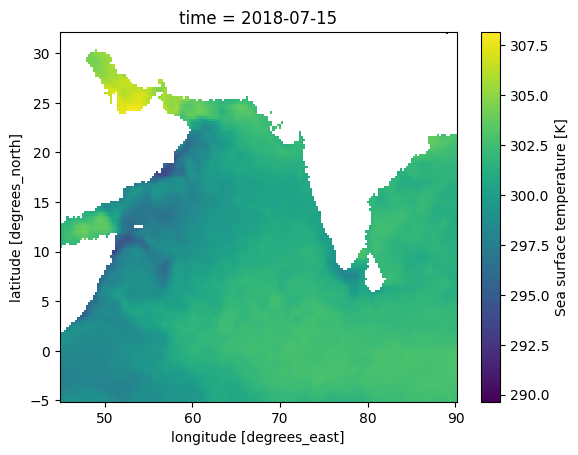

In [53]:
p = zarr_new.sel(time='2018-07-15').sst.plot(y='lat', x='lon')

#### Function: `preprocess_day_data`

The `preprocess_day_data` function processes daily SST data by removing the mean value for each day. This helps in normalizing the data.

#### Function: `preprocess_data`

The `preprocess_data` function processes the entire dataset by dividing it into chunks and applying the `preprocess_day_data` function to each chunk. It also handles NaN values by replacing them with 0.0.

#### Function: `prepare_data_from_processed`

The `prepare_data_from_processed` function prepares the processed data for training by creating input sequences (`X`) and corresponding targets (`y`). Each input sequence contains a window of SST data.

In [40]:
def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(zarr_ds).compute()

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

#### Function: `time_series_split`

The `time_series_split` function splits the input data into training, validation, and test sets based on specified ratios. This is particularly important for time series data to maintain the temporal order.

The ratio for train, validation, and test set is 70%, 20%, 10%, which is the most common combination in ML tasks.

In [41]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

#### Function: `create_improved_model`

The `create_improved_model` function defines and constructs a deep learning model using the Sequential API from TensorFlow's Keras. The model architecture includes a ConvLSTM2D layer followed by several Conv2D layers, each with batch normalization and dropout for regularization.

- **Parameters**:
  - `input_shape`: The shape of the input data. Default is `(5, 149, 181, 1)`, where `5` is the time step window size, `149` and `181` are the spatial dimensions (latitude and longitude), and `1` is the number of channels.

- **Returns**:
  - A compiled Keras model ready for training.

#### Model Architecture

1. **ConvLSTM2D Layer**:
   - **Purpose**: This layer combines convolutional operations with LSTM to capture both spatial and temporal dependencies in the input data. It processes sequences of images (time series of spatial data) to learn spatiotemporal features.

2. **BatchNormalization**:
   - **Purpose**: Normalizes the activations of the previous layer to speed up training and reduce sensitivity to initialization. It helps stabilize and accelerate the training process by maintaining the mean output close to 0 and the output standard deviation close to 1.

3. **Dropout**:
   - **Purpose**: Randomly sets a fraction of input units to 0 at each update during training time to prevent overfitting. In this case, 30% of the input units are dropped out.

4. **Conv2D Layer**:
   - **Purpose**: Applies convolutional filters to the input data to capture spatial features. This layer uses ReLU activation to introduce non-linearity and help the model learn more complex patterns.

5. **Output Layer (Conv2D)**:
    - **Purpose**: The final convolutional layer with a linear activation function to predict the SST values. This layer reduces the output to a single channel representing the SST predictions.
  
### Explanation of Model Parameters and Common Activation Functions

#### Parameters

- **`filters`: 32**
  - **Description**: The number of output filters in the convolution. This parameter defines how many different features the layer will learn to extract from the input. More filters can capture more complex patterns but also increase the computational cost.

- **`kernel_size`: (3, 3)**
  - **Description**: The size of the convolutional kernel (filter). A (3, 3) kernel means that the filter will look at a 3x3 patch of the input at a time. Smaller kernels capture finer details, while larger kernels capture more global patterns.

- **`padding`: 'same'**
  - **Description**: This parameter determines how the padding is applied to the input data. 'same' padding means that the output will have the same spatial dimensions (height and width) as the input. This is achieved by padding the input with zeros around the border as needed.

- **`return_sequences`: False**
  - **Description**: In the context of LSTM layers, this parameter determines whether to return the last output in the output sequence (`False`) or the full sequence of outputs (`True`). For ConvLSTM2D, setting `return_sequences` to `False` means that only the final output of the sequence will be returned, not the entire sequence.
#### Common Activation Functions

- **ReLU (Rectified Linear Unit)**
  - **Description**: `ReLU(x) = max(0, x)`. It outputs the input directly if it is positive; otherwise, it will output zero. ReLU helps in mitigating the vanishing gradient problem and allows the model to learn faster.
  - **Common Use Cases**: Hidden layers in neural networks.

- **Sigmoid**
  - **Description**: `Sigmoid(x) = 1 / (1 + exp(-x))`. It outputs values between 0 and 1, which can be interpreted as probabilities. Sigmoid functions are useful for binary classification problems.
  - **Common Use Cases**: Output layer for binary classification.

- **Softmax**
  - **Description**: `Softmax(x_i) = exp(x_i) / sum(exp(x_j))`. It converts a vector of values into a probability distribution, where the sum of all probabilities is 1. Softmax is often used in the output layer of classification problems with multiple classes.
  - **Common Use Cases**: Output layer for multi-class classification.

In [42]:
def create_improved_model(input_shape=(5, 149, 181, 1)):
    model = Sequential()

    # ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Additional Conv2D layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

model = create_improved_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_7 (ConvLSTM2D)  (None, 149, 181, 32)      38144     
                                                                 
 batch_normalization_10 (Bat  (None, 149, 181, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 149, 181, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 149, 181, 64)      18496     
                                                                 
 batch_normalization_11 (Bat  (None, 149, 181, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 149, 181, 64)     

### Model Compilation and Training

#### Compilation

The model is compiled with the following configurations:
- **Optimizer**: 'adam'
  - The Adam optimizer is used for its efficiency in training deep learning models by adaptively adjusting the learning rate.
- **Loss Function**: 'mae' (Mean Absolute Error)
  - MAE is chosen for its simplicity and effectiveness in regression tasks, providing a direct measure of the average absolute errors between predicted and actual values.
- **Metrics**: ['mae']
  - MAE is also used as a metric to evaluate the model's performance during training and validation.

#### Early Stopping

To prevent overfitting and save training time, an early stopping callback is used:
- **EarlyStopping**: Monitors the validation loss and stops training if it doesn't improve for 10 consecutive epochs.
  - **patience**: 10
  - **restore_best_weights**: True
    - Ensures the model restores its best weights obtained during training when early stopping is triggered.

#### Data Preparation

The training and validation datasets are prepared using TensorFlow's `tf.data.Dataset` API:
- **Train Dataset**:
  - Created from `X_train` and `y_train`.
  - Shuffled with a buffer size of 1024 to ensure randomness in each batch.
  - Batched into mini-batches of size 4 for training.
  - **Notice**: You can start by using a larger batch size like 32, and only narrow down the batch size if memory issues occur.
- **Validation Dataset**:
  - Created from `X_val` and `y_val`.
  - Batched into mini-batches of size 4 for validation.

#### Training

The model is trained using the prepared datasets and early stopping callback:
- **Epochs**: 50
  - The training process runs for up to 50 epochs, with early stopping potentially halting it sooner.
- **Validation Data**: `val_dataset`
  - The validation data is used to monitor the model's performance and trigger early stopping if necessary.
- **Callbacks**: [early_stop]
  - The early stopping callback is included to halt training when improvement ceases.


In [29]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(4)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(4)

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/50
483/483 [==============================] - 56s 111ms/step - loss: 0.1785 - mae: 0.1785 - val_loss: 0.1043 - val_mae: 0.1043
Epoch 2/50
483/483 [==============================] - 53s 110ms/step - loss: 0.1799 - mae: 0.1799 - val_loss: 0.1079 - val_mae: 0.1079
Epoch 3/50
483/483 [==============================] - 54s 111ms/step - loss: 0.1777 - mae: 0.1777 - val_loss: 0.1004 - val_mae: 0.1004
Epoch 4/50
483/483 [==============================] - 53s 110ms/step - loss: 0.1756 - mae: 0.1756 - val_loss: 0.1149 - val_mae: 0.1149
Epoch 5/50
483/483 [==============================] - 54s 111ms/step - loss: 0.1691 - mae: 0.1691 - val_loss: 0.1290 - val_mae: 0.1290
Epoch 6/50
483/483 [==============================] - 53s 110ms/step - loss: 0.1533 - mae: 0.1533 - val_loss: 0.1027 - val_mae: 0.1027
Epoch 7/50
483/483 [==============================] - 54s 111ms/step - loss: 0.1417 - mae: 0.1417 - val_loss: 0.1112 - val_mae: 0.1112
Epoch 8/50
483/483 [==============================] - 5

### Visualizing Training History

To understand how the model's performance improves over time, we can visualize the training and validation loss, as well as the Mean Absolute Error (MAE) over the epochs.

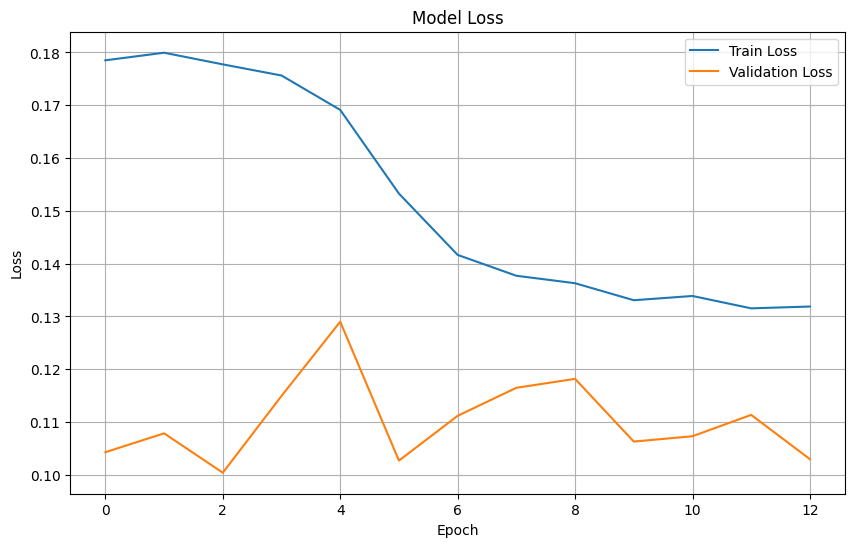

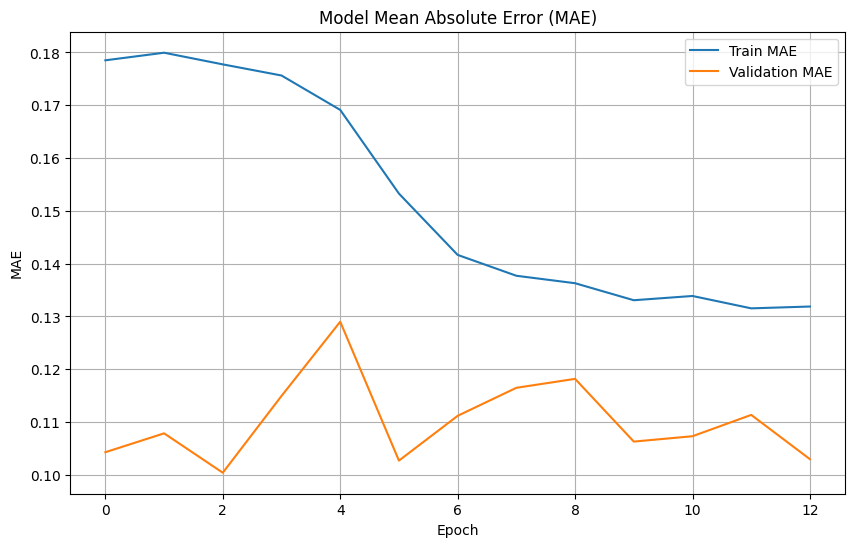

In [45]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Evaluating the Model on the Test Dataset

After training the model, it's important to evaluate its performance on a separate test dataset to ensure it generalizes well to unseen data.

- **Notice**: If you find the training loss (or MAE) is significantly less than the validation loss (or MAE) or the test loss (or MAE), then overfitting is likely to happen.
- **General Solutions To Overfitting**:
    - L2 Regularization: Adds a penalty equal to the square of the magnitude of coefficients to the loss function.
    - Dropout: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
    - Simplify the model: Reduce the complexity of the model by decreasing the number of layers or the number of units in each layer.
    - Increase Training Data: Gather more training data if possible, as more data can help the model learn to generalize better.
    - Early Stopping: Monitor the validation loss during training and stop training when the validation loss stops improving.

In [51]:
# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

69/69 [==============================] - 4s 46ms/step - loss: 0.1042 - mae: 0.1042
Test Loss: 0.10424796491861343
Test MAE: 0.10424796491861343


#### Saving the Model

Save the entire model, including the architecture, weights, and optimizer state.

You can use `model = tf.keras.models.load_model('ConvLSTM_SST.keras')` to load the saved model for further training or evaluation.

In [35]:
model.save('ConvLSTM_SST.keras')

### Functions for Visualizing Model Predictions

Here are some utility functions to preprocess input data, postprocess predictions, and visualize the results of the trained model's predictions.

#### Preprocess Input Data

The `preprocess_vis_input_data` function preprocesses the input data by normalizing it and handling NaN values.

#### Postprocess Prediction

The `postprocess_prediction` function postprocesses the model's prediction by applying a land mask and adding back the historical mean.

#### Predict and Plot

The `predict_and_plot` function selects a time window, makes a prediction, postprocesses it, and visualizes the input, predicted, and true output data.

#### Compute MAE

The `compute_mae` function computes the Mean Absolute Error (MAE) between true and predicted values, ignoring NaNs.

In [30]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask_nc.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

#### Predict and Plot

First, we select a date to predict and define the window size for the input data. We then use the `predict_and_plot` function to get the input data, predicted output, and true output for the specified date. 

A useful comparison standard is that the MAE between the predicted output and the true output should be smaller than the MAE between the last input frame and the true output. This indicates that the model's prediction is closer to the true output than simply using the last known input.


(5, 149, 181)
(149, 181)
1/1 [==============================] - 0s 23ms/step
(149, 181, 1)


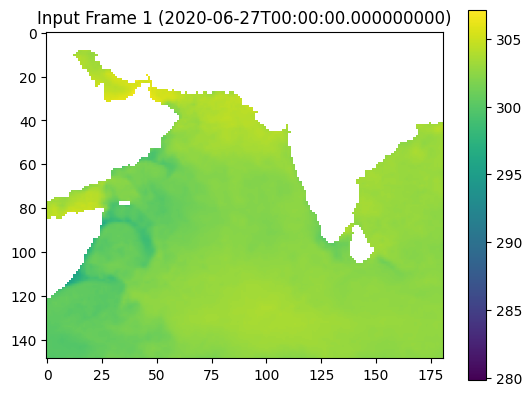

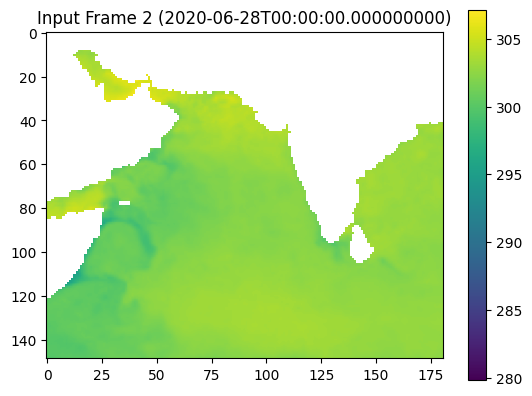

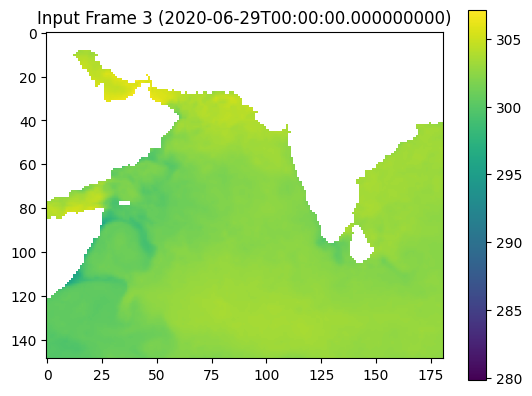

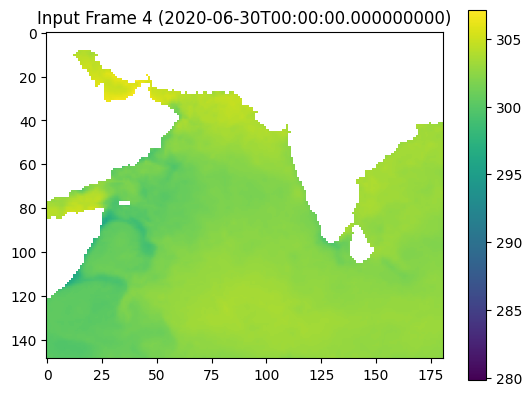

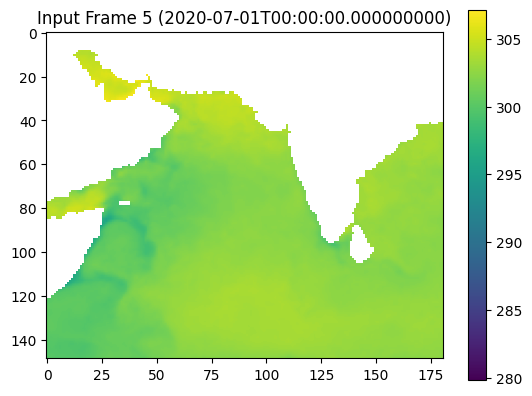

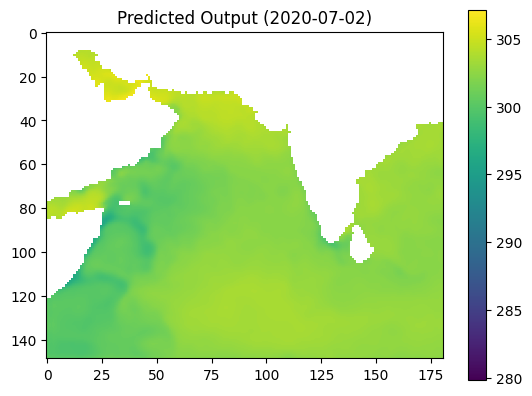

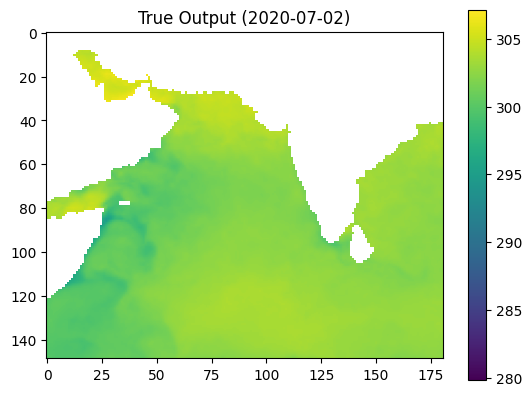

MAE between Predicted Output and True Output: 0.13109762966632843
MAE between Last Input Frame and True Output: 0.13788197934627533


In [34]:
date_to_predict = '2020-07-02'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")